# Single Chain Protein Feature Extraction with abagpdb

This notebook demonstrates how to extract comprehensive features from **individual protein chains** (not complexes). This is useful for:

- **Protein structure quality assessment**
- **Sequence-structure relationship analysis**
- **Stability predictions**
- **Fold classification**
- **Machine learning on single proteins**

## Features Extracted for Single Chains:

Unlike the complex analysis in `nb8-residue_features.ipynb`, this focuses on **intrinsic properties**:

1. **Basic Properties**: Chain, residue name, sequence position
2. **Sequence Context**: Position in chain, N/C-terminal location, relative position
3. **Structural Geometry**: Backbone angles (φ, ψ, ω), sidechain rotamers (χ1-4), bend angles
4. **Secondary Structure**: Helix, sheet, loop classification from φ/ψ angles
5. **Surface Accessibility**: SASA, relative SASA, buried/exposed classification
6. **Local Environment**: CA-CA distances to sequence neighbors, distance from chain center
7. **Chemical Properties**: Charge, polarity, hydrophobicity, aromaticity, size
8. **Atomic Composition**: Heavy atom counts, element counts (C, N, O, S)
9. **B-factors**: Mean, max, min, standard deviation
10. **Occupancy**: Average and minimum occupancy

---

## 1. Setup and Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

In [ ]:
from PyPDBcomplex.pdbparser import parse_pdb
from PyPDBcomplex.single_chain_features import (
    extract_single_chain_features,
    features_to_dataframe,
    export_features_csv,
    export_features_json,
    get_feature_summary
)

## 2. Load PDB Structure

We'll analyze individual chains from the 5GGS structure:
- **Chain A**: Antigen protein
- **Chain H**: Antibody heavy chain
- **Chain L**: Antibody light chain

In [3]:
# Parse PDB file
cx = parse_pdb("5GGS_wt.pdb")

print("=" * 60)
print("PDB STRUCTURE LOADED".center(60))
print("=" * 60)
print(f"File:         5GGS_wt.pdb")
print(f"Chains:       {', '.join(cx.chains.keys())}")
print("\nChain Information:")
for chain_id, chain in cx.chains.items():
    num_res = len(list(chain.iter_residues()))
    print(f"  Chain {chain_id}: {num_res} residues")
print("=" * 60)

                    PDB STRUCTURE LOADED                    
File:         5GGS_wt.pdb
Chains:       A, H, L

Chain Information:
  Chain A: 113 residues
  Chain H: 219 residues
  Chain L: 217 residues


## 3. Extract Features for a Single Chain

Let's start by analyzing **Chain A** (the antigen protein).

In [4]:
# Extract features for Chain A
features_A = extract_single_chain_features(
    cx=cx,
    chain_ids="A",  # Can also use ["A"] or "A,B,C" for multiple chains
    compute_sasa=True,
    compute_geometry=True,
    verbose=True
)

Starting single chain residue feature extraction...
  Total residues to analyze: 113
  Chains: A
  [1/5] Initializing basic features...
  [2/5] Computing distances from chain centers...
  [3/5] Computing local CA-CA distances...
  [4/5] Computing backbone and sidechain angles...
  [5/5] Computing solvent accessible surface area...
  Feature extraction complete! Generated features for 113 residues.
  - Alpha helix: 14
  - Beta sheet:  56
  - Loop/other:  37
  - Buried residues:  0
  - Exposed residues: 0


## 4. Inspect Feature Data

In [5]:
print(f"\nTotal residues analyzed: {len(features_A)}")
print(f"\nFirst 5 residue IDs:")
for i, res_id in enumerate(list(features_A.keys())[:5]):
    print(f"  {i+1}. {res_id}")


Total residues analyzed: 113

First 5 residue IDs:
  1. PRO A:1
  2. TRP A:2
  3. ASN A:3
  4. PRO A:4
  5. PRO A:5


In [6]:
# Examine a single residue in detail
sample_res_id = "TYR A:46"  # Pick an interesting residue

# If this residue doesn't exist, pick the 45th residue
if sample_res_id not in features_A:
    sample_res_id = list(features_A.keys())[45] if len(features_A) > 45 else list(features_A.keys())[0]

sample_feat = features_A[sample_res_id]

print("=" * 80)
print(f"DETAILED VIEW: {sample_res_id}".center(80))
print("=" * 80)

print(f"\n📍 Basic Information:")
print(f"   Residue:            {sample_feat.resname}")
print(f"   Chain:              {sample_feat.chain_id}")
print(f"   Sequence number:    {sample_feat.resseq}")
print(f"   Position in chain:  {sample_feat.position_in_chain + 1}/{sample_feat.sequence_length}")
print(f"   Relative position:  {sample_feat.relative_position:.2%}")
print(f"   N-terminal:         {sample_feat.is_n_terminal}")
print(f"   C-terminal:         {sample_feat.is_c_terminal}")

print(f"\n🧪 Chemical Properties:")
print(f"   Charged:            {sample_feat.is_charged}")
print(f"   Polar:              {sample_feat.is_polar}")
print(f"   Hydrophobic:        {sample_feat.is_hydrophobic}")
print(f"   Aromatic:           {sample_feat.is_aromatic}")
print(f"   Small:              {sample_feat.is_small}")

print(f"\n⚛️  Atomic Composition:")
print(f"   Heavy atoms:        {sample_feat.num_heavy_atoms}")
print(f"   Carbon atoms:       {sample_feat.num_carbon_atoms}")
print(f"   Nitrogen atoms:     {sample_feat.num_nitrogen_atoms}")
print(f"   Oxygen atoms:       {sample_feat.num_oxygen_atoms}")
print(f"   Sulfur atoms:       {sample_feat.num_sulfur_atoms}")

print(f"\n📐 Geometry:")
if sample_feat.phi is not None:
    print(f"   Phi (φ):            {sample_feat.phi:.2f}°")
    print(f"   Psi (ψ):            {sample_feat.psi:.2f}°")
    print(f"   Omega (ω):          {sample_feat.omega:.2f}°" if sample_feat.omega else "   Omega (ω):          N/A")
else:
    print(f"   Backbone angles:    N/A")

if sample_feat.chi1 is not None:
    print(f"   Chi1 (χ1):          {sample_feat.chi1:.2f}°")
    if sample_feat.chi2:
        print(f"   Chi2 (χ2):          {sample_feat.chi2:.2f}°")
else:
    print(f"   Sidechain rotamers: N/A")

print(f"   Bend angle:         {sample_feat.bend_angle:.2f}°" if sample_feat.bend_angle else "   Bend angle:         N/A")
print(f"   Secondary struct:   {sample_feat.secondary_structure if sample_feat.secondary_structure else 'N/A'}")

print(f"\n💧 Surface Accessibility:")
if sample_feat.sasa is not None:
    print(f"   SASA:               {sample_feat.sasa:.2f} Ų")
    print(f"   Relative SASA:      {sample_feat.relative_sasa:.2%}")
    print(f"   Buried:             {sample_feat.is_buried}")
    print(f"   Exposed:            {sample_feat.is_exposed}")
else:
    print(f"   SASA:               Not available")

print(f"\n📏 Local Environment:")
print(f"   CA dist to i-1:     {sample_feat.ca_dist_to_prev:.2f} Å" if sample_feat.ca_dist_to_prev else "   CA dist to i-1:     N/A")
print(f"   CA dist to i+1:     {sample_feat.ca_dist_to_next:.2f} Å" if sample_feat.ca_dist_to_next else "   CA dist to i+1:     N/A")
print(f"   Avg local CA dist:  {sample_feat.avg_local_ca_distance:.2f} Å" if sample_feat.avg_local_ca_distance else "   Avg local CA dist:  N/A")
print(f"   Dist from center:   {sample_feat.dist_from_chain_center:.2f} Å" if sample_feat.dist_from_chain_center else "   Dist from center:   N/A")

print(f"\n📊 B-factors:")
if sample_feat.avg_bfactor is not None:
    print(f"   Average:            {sample_feat.avg_bfactor:.2f}")
    print(f"   Min:                {sample_feat.min_bfactor:.2f}")
    print(f"   Max:                {sample_feat.max_bfactor:.2f}")
    print(f"   Std Dev:            {sample_feat.std_bfactor:.2f}" if sample_feat.std_bfactor else "   Std Dev:            N/A")
else:
    print(f"   B-factors:          Not available")

print("=" * 80)

                            DETAILED VIEW: THR A:46                             

📍 Basic Information:
   Residue:            THR
   Chain:              A
   Sequence number:    46
   Position in chain:  46/113
   Relative position:  39.82%
   N-terminal:         False
   C-terminal:         False

🧪 Chemical Properties:
   Charged:            False
   Polar:              True
   Hydrophobic:        False
   Aromatic:           False
   Small:              False

⚛️  Atomic Composition:
   Heavy atoms:        7
   Carbon atoms:       4
   Nitrogen atoms:     1
   Oxygen atoms:       2
   Sulfur atoms:       0

📐 Geometry:
   Phi (φ):            -86.75°
   Psi (ψ):            104.82°
   Omega (ω):          178.83°
   Chi1 (χ1):          52.19°
   Bend angle:         105.99°
   Secondary struct:   loop

💧 Surface Accessibility:
   SASA:               Not available

📏 Local Environment:
   CA dist to i-1:     3.80 Å
   CA dist to i+1:     3.82 Å
   Avg local CA dist:  5.14 Å
   Dist from 

## 5. Convert to Pandas DataFrame

In [7]:
# Convert to DataFrame
df_A = features_to_dataframe(features_A)

print(f"DataFrame shape: {df_A.shape}")
print(f"Columns ({len(df_A.columns)}):")
for i, col in enumerate(df_A.columns, 1):
    print(f"  {i:2d}. {col}")

DataFrame shape: (113, 52)
Columns (52):
   1. chain_id
   2. resname
   3. resseq
   4. icode
   5. residue_id
   6. position_in_chain
   7. sequence_length
   8. relative_position
   9. is_n_terminal
  10. is_c_terminal
  11. phi
  12. psi
  13. omega
  14. bend_angle
  15. chi1
  16. chi2
  17. chi3
  18. chi4
  19. secondary_structure
  20. sasa
  21. relative_sasa
  22. is_buried
  23. is_exposed
  24. ca_dist_to_prev
  25. ca_dist_to_next
  26. ca_dist_to_prev2
  27. ca_dist_to_next2
  28. avg_local_ca_distance
  29. centroid_x
  30. centroid_y
  31. centroid_z
  32. dist_from_chain_center
  33. is_charged
  34. is_polar
  35. is_hydrophobic
  36. is_aromatic
  37. is_positive
  38. is_negative
  39. is_small
  40. is_tiny
  41. num_heavy_atoms
  42. num_all_atoms
  43. num_carbon_atoms
  44. num_nitrogen_atoms
  45. num_oxygen_atoms
  46. num_sulfur_atoms
  47. avg_bfactor
  48. max_bfactor
  49. min_bfactor
  50. std_bfactor
  51. avg_occupancy
  52. min_occupancy


In [8]:
# Display first rows
df_A.head(10)

,chain_id,resname,resseq,icode,residue_id,position_in_chain,sequence_length,relative_position,is_n_terminal,is_c_terminal,...,num_carbon_atoms,num_nitrogen_atoms,num_oxygen_atoms,num_sulfur_atoms,avg_bfactor,max_bfactor,min_bfactor,std_bfactor,avg_occupancy,min_occupancy
0,A,PRO,1,,PRO A:1,0,113,0.000000,True,False,...,5,1,1,0,60.644286,69.05,55.10,4.443155,1.0,1.0
1,A,TRP,2,,TRP A:2,1,113,0.008850,True,False,...,11,2,1,0,43.902143,54.28,34.02,5.795747,1.0,1.0
2,A,ASN,3,,ASN A:3,2,113,0.017699,True,False,...,4,2,2,0,48.366250,59.02,40.06,6.414220,1.0,1.0
3,A,PRO,4,,PRO A:4,3,113,0.026549,True,False,...,5,1,1,0,38.778571,41.38,34.91,2.062013,1.0,1.0
4,A,PRO,5,,PRO A:5,4,113,0.035398,True,False,...,5,1,1,0,37.760000,39.34,34.83,1.285413,1.0,1.0
5,A,THR,6,,THR A:6,5,113,0.044248,False,False,...,4,1,2,0,38.740000,44.02,35.43,2.866162,1.0,1.0
6,A,PHE,7,,PHE A:7,6,113,0.053097,False,False,...,9,1,1,0,35.582727,48.37,31.49,4.965091,1.0,1.0
7,A,SER,8,,SER A:8,7,113,0.061947,False,False,...,3,1,2,0,48.155000,54.65,42.80,3.974702,1.0,1.0
8,A,PRO,9,,PRO A:9,8,113,0.070796,False,False,...,5,1,1,0,47.720000,51.66,43.84,2.582645,1.0,1.0
9,A,ALA,10,,ALA A:10,9,113,0.079646,False,False,...,3,1,1,0,51.158000,57.49,44.20,4.824116,1.0,1.0


## 6. Feature Summary Statistics

In [9]:
# Get summary statistics
summary = get_feature_summary(features_A)

print("=" * 60)
print("CHAIN A FEATURE SUMMARY".center(60))
print("=" * 60)

print(f"\n📊 Basic Statistics:")
print(f"   Total residues:     {summary['total_residues']}")
print(f"   Number of chains:   {summary['chains']}")

print(f"\n🧬 Secondary Structure:")
print(f"   Alpha helix:        {summary['alpha_helix']} ({summary['alpha_helix']/summary['total_residues']*100:.1f}%)")
print(f"   Beta sheet:         {summary['beta_sheet']} ({summary['beta_sheet']/summary['total_residues']*100:.1f}%)")
print(f"   Loop/other:         {summary['loop']} ({summary['loop']/summary['total_residues']*100:.1f}%)")

print(f"\n🧪 Chemical Properties:")
print(f"   Charged:            {summary['charged_residues']} ({summary['charged_residues']/summary['total_residues']*100:.1f}%)")
print(f"   Hydrophobic:        {summary['hydrophobic_residues']} ({summary['hydrophobic_residues']/summary['total_residues']*100:.1f}%)")
print(f"   Aromatic:           {summary['aromatic_residues']} ({summary['aromatic_residues']/summary['total_residues']*100:.1f}%)")
print(f"   Polar:              {summary['polar_residues']} ({summary['polar_residues']/summary['total_residues']*100:.1f}%)")

print(f"\n💧 Surface Accessibility:")
print(f"   Buried (<20% SASA): {summary['buried_residues']} ({summary['buried_residues']/summary['total_residues']*100:.1f}%)")
print(f"   Exposed (>50% SASA):{summary['exposed_residues']} ({summary['exposed_residues']/summary['total_residues']*100:.1f}%)")

if 'avg_bfactor' in summary:
    print(f"\n📊 B-factors:")
    print(f"   Average:            {summary['avg_bfactor']:.2f}")
    print(f"   Min:                {summary['min_bfactor']:.2f}")
    print(f"   Max:                {summary['max_bfactor']:.2f}")

print("=" * 60)

                  CHAIN A FEATURE SUMMARY                   

📊 Basic Statistics:
   Total residues:     113
   Number of chains:   1

🧬 Secondary Structure:
   Alpha helix:        14 (12.4%)
   Beta sheet:         56 (49.6%)
   Loop/other:         37 (32.7%)

🧪 Chemical Properties:
   Charged:            25 (22.1%)
   Hydrophobic:        46 (40.7%)
   Aromatic:           12 (10.6%)
   Polar:              37 (32.7%)

💧 Surface Accessibility:
   Buried (<20% SASA): 0 (0.0%)
   Exposed (>50% SASA):0 (0.0%)

📊 B-factors:
   Average:            46.22
   Min:                22.42
   Max:                88.97


## 7. Visualizations

### 7.1 Secondary Structure Distribution Along Sequence

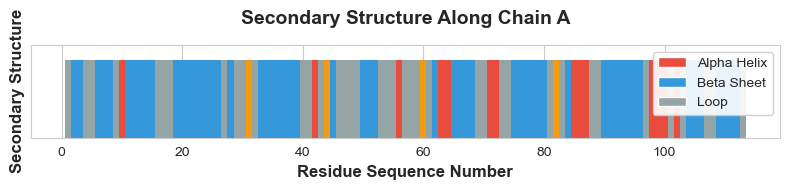

In [11]:
# Plot secondary structure along sequence
fig, ax = plt.subplots(figsize=(8, 2))

# Color map for secondary structure
ss_colors = {
    'alpha_helix': '#e74c3c',
    'beta_sheet': '#3498db',
    'loop': '#95a5a6',
    'left_helix': '#f39c12'
}

colors = [ss_colors.get(ss, '#95a5a6') for ss in df_A['secondary_structure']]

ax.bar(df_A['resseq'], [1]*len(df_A), color=colors, edgecolor='none', width=1.0)
ax.set_xlabel('Residue Sequence Number', fontsize=12, fontweight='bold')
ax.set_ylabel('Secondary Structure', fontsize=12, fontweight='bold')
ax.set_title('Secondary Structure Along Chain A', fontsize=14, fontweight='bold', pad=15)
ax.set_ylim(0, 1.2)
ax.set_yticks([])

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#e74c3c', label='Alpha Helix'),
    Patch(facecolor='#3498db', label='Beta Sheet'),
    Patch(facecolor='#95a5a6', label='Loop')
]
ax.legend(handles=legend_elements, loc='upper right', framealpha=0.9)

plt.tight_layout()
plt.show()

### 7.2 Ramachandran Plot

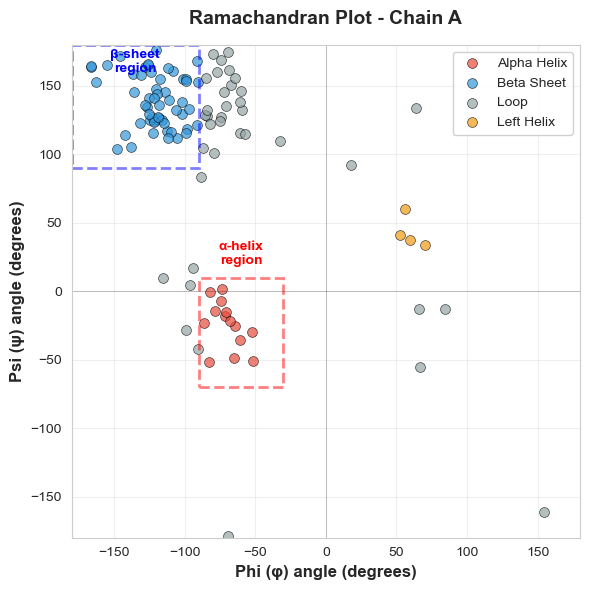

In [16]:
# Ramachandran plot
df_rama = df_A.dropna(subset=['phi', 'psi'])

if len(df_rama) > 0:
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Color by secondary structure
    for ss, color in ss_colors.items():
        subset = df_rama[df_rama['secondary_structure'] == ss]
        if len(subset) > 0:
            ax.scatter(subset['phi'], subset['psi'], 
                      c=color, label=ss.replace('_', ' ').title(),
                      alpha=0.7, s=50, edgecolors='black', linewidth=0.5)
    
    # Draw typical regions
    # Alpha helix region
    ax.add_patch(plt.Rectangle((-90, -70), 60, 80, 
                               fill=False, edgecolor='red', linewidth=2, 
                               linestyle='--', alpha=0.5))
    ax.text(-60, 20, 'α-helix\nregion', fontsize=10, color='red', 
            fontweight='bold', ha='center')
    
    # Beta sheet region  
    ax.add_patch(plt.Rectangle((-180, 90), 90, 90,
                               fill=False, edgecolor='blue', linewidth=2,
                               linestyle='--', alpha=0.5))
    ax.text(-135, 160, 'β-sheet\nregion', fontsize=10, color='blue', 
            fontweight='bold', ha='center')
    
    ax.set_xlabel('Phi (φ) angle (degrees)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Psi (ψ) angle (degrees)', fontsize=12, fontweight='bold')
    ax.set_title('Ramachandran Plot - Chain A', fontsize=14, fontweight='bold', pad=15)
    ax.set_xlim(-180, 180)
    ax.set_ylim(-180, 180)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
    ax.axvline(x=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
    ax.legend(loc='best', framealpha=0.9)
    
    plt.tight_layout()
    plt.show()
else:
    print("No phi/psi data available")

### 7.3 SASA Analysis

In [17]:
# SASA analysis
df_sasa = df_A.dropna(subset=['sasa', 'relative_sasa'])

if len(df_sasa) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    
    # 1. SASA along sequence
    colors_buried = ['#e74c3c' if buried else '#3498db' 
                     for buried in df_sasa['is_buried']]
    
    axes[0].bar(df_sasa['resseq'], df_sasa['sasa'], 
                color=colors_buried, edgecolor='none', width=1.0)
    axes[0].set_xlabel('Residue Number', fontsize=11, fontweight='bold')
    axes[0].set_ylabel('SASA (Ų)', fontsize=11, fontweight='bold')
    axes[0].set_title('Solvent Accessible Surface Area', fontsize=12, fontweight='bold')
    
    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#e74c3c', label='Buried (<20%)'),
        Patch(facecolor='#3498db', label='Exposed')
    ]
    axes[0].legend(handles=legend_elements, loc='upper right')
    
    # 2. Relative SASA distribution
    axes[1].hist(df_sasa['relative_sasa'], bins=30, color='#9b59b6', 
                 edgecolor='black', alpha=0.7)
    axes[1].axvline(0.2, color='red', linestyle='--', linewidth=2, label='Buried cutoff (20%)')
    axes[1].axvline(0.5, color='blue', linestyle='--', linewidth=2, label='Exposed cutoff (50%)')
    axes[1].set_xlabel('Relative SASA', fontsize=11, fontweight='bold')
    axes[1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
    axes[1].set_title('Relative SASA Distribution', fontsize=12, fontweight='bold')
    axes[1].legend()
    
    # 3. SASA by residue type
    sasa_by_type = df_sasa.groupby('resname')['relative_sasa'].mean().sort_values(ascending=False)
    
    colors_gradient = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(sasa_by_type)))
    bars = axes[2].barh(range(len(sasa_by_type)), sasa_by_type.values,
                        color=colors_gradient, edgecolor='black', linewidth=1)
    axes[2].set_yticks(range(len(sasa_by_type)))
    axes[2].set_yticklabels(sasa_by_type.index)
    axes[2].set_xlabel('Average Relative SASA', fontsize=11, fontweight='bold')
    axes[2].set_title('SASA by Residue Type', fontsize=12, fontweight='bold')
    axes[2].axvline(0.2, color='red', linestyle='--', linewidth=1, alpha=0.5)
    axes[2].axvline(0.5, color='blue', linestyle='--', linewidth=1, alpha=0.5)
    axes[2].invert_yaxis()
    
    plt.tight_layout()
    plt.show()
else:
    print("No SASA data available")

No SASA data available


### 7.4 B-factor Analysis

/var/folders/tg/f0jwz81x22s5z6lnwt1nxtn00000gp/T/ipykernel_2495/4088895686.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot(ss_data, labels=ss_labels_filtered, patch_artist=True,


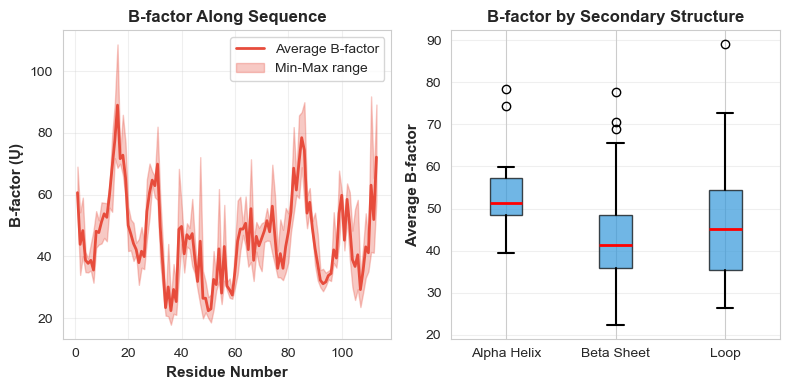


B-factor Statistics by Secondary Structure:
  Alpha Helix    : Mean=54.24, Median=51.37, Std=10.83
  Beta Sheet     : Mean=42.90, Median=41.44, Std=12.16
  Loop           : Mean=46.13, Median=45.24, Std=14.43


In [18]:
# B-factor analysis
df_bfactor = df_A.dropna(subset=['avg_bfactor'])

if len(df_bfactor) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
    # 1. B-factor along sequence
    axes[0].plot(df_bfactor['resseq'], df_bfactor['avg_bfactor'], 
                 color='#e74c3c', linewidth=2, label='Average B-factor')
    axes[0].fill_between(df_bfactor['resseq'], 
                          df_bfactor['min_bfactor'], 
                          df_bfactor['max_bfactor'],
                          alpha=0.3, color='#e74c3c', label='Min-Max range')
    axes[0].set_xlabel('Residue Number', fontsize=11, fontweight='bold')
    axes[0].set_ylabel('B-factor (Ų)', fontsize=11, fontweight='bold')
    axes[0].set_title('B-factor Along Sequence', fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 2. B-factor distribution by secondary structure
    ss_order = ['alpha_helix', 'beta_sheet', 'loop']
    ss_labels = ['Alpha Helix', 'Beta Sheet', 'Loop']
    ss_data = [df_bfactor[df_bfactor['secondary_structure'] == ss]['avg_bfactor'].values 
               for ss in ss_order if ss in df_bfactor['secondary_structure'].values]
    ss_labels_filtered = [ss_labels[i] for i, ss in enumerate(ss_order) 
                          if ss in df_bfactor['secondary_structure'].values]
    
    bp = axes[1].boxplot(ss_data, labels=ss_labels_filtered, patch_artist=True,
                         boxprops=dict(facecolor='#3498db', alpha=0.7),
                         medianprops=dict(color='red', linewidth=2),
                         whiskerprops=dict(linewidth=1.5),
                         capprops=dict(linewidth=1.5))
    
    axes[1].set_ylabel('Average B-factor', fontsize=11, fontweight='bold')
    axes[1].set_title('B-factor by Secondary Structure', fontsize=12, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    print("\nB-factor Statistics by Secondary Structure:")
    for ss, label in zip(ss_order, ss_labels):
        if ss in df_bfactor['secondary_structure'].values:
            values = df_bfactor[df_bfactor['secondary_structure'] == ss]['avg_bfactor']
            print(f"  {label:15s}: Mean={values.mean():.2f}, Median={values.median():.2f}, Std={values.std():.2f}")
else:
    print("No B-factor data available")

### 7.5 Chemical Properties Distribution

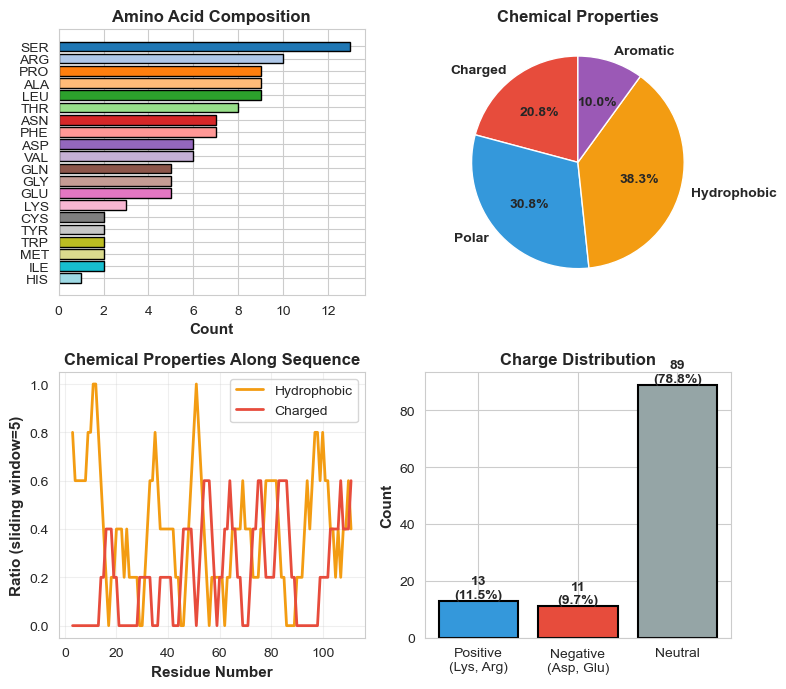


Net charge: +2 (13 positive - 11 negative)


In [19]:
# Chemical properties
fig, axes = plt.subplots(2, 2, figsize=(8, 7))

# 1. Residue composition
aa_counts = df_A['resname'].value_counts()
colors_aa = plt.cm.tab20(np.linspace(0, 1, len(aa_counts)))

bars = axes[0,0].barh(range(len(aa_counts)), aa_counts.values, 
                      color=colors_aa, edgecolor='black', linewidth=1)
axes[0,0].set_yticks(range(len(aa_counts)))
axes[0,0].set_yticklabels(aa_counts.index)
axes[0,0].set_xlabel('Count', fontsize=11, fontweight='bold')
axes[0,0].set_title('Amino Acid Composition', fontsize=12, fontweight='bold')
axes[0,0].invert_yaxis()

# 2. Chemical property pie chart
properties = {
    'Charged': df_A['is_charged'].sum(),
    'Polar': df_A['is_polar'].sum(),
    'Hydrophobic': df_A['is_hydrophobic'].sum(),
    'Aromatic': df_A['is_aromatic'].sum(),
}

axes[0,1].pie(properties.values(), labels=properties.keys(), autopct='%1.1f%%',
              colors=['#e74c3c', '#3498db', '#f39c12', '#9b59b6'],
              startangle=90, textprops={'fontweight': 'bold'})
axes[0,1].set_title('Chemical Properties', fontsize=12, fontweight='bold')

# 3. Position-based properties
window_size = 5
hydrophobic_ratio = df_A['is_hydrophobic'].rolling(window=window_size, center=True).mean()
charged_ratio = df_A['is_charged'].rolling(window=window_size, center=True).mean()

axes[1,0].plot(df_A['resseq'], hydrophobic_ratio, 
               color='#f39c12', linewidth=2, label='Hydrophobic')
axes[1,0].plot(df_A['resseq'], charged_ratio, 
               color='#e74c3c', linewidth=2, label='Charged')
axes[1,0].set_xlabel('Residue Number', fontsize=11, fontweight='bold')
axes[1,0].set_ylabel(f'Ratio (sliding window={window_size})', fontsize=11, fontweight='bold')
axes[1,0].set_title('Chemical Properties Along Sequence', fontsize=12, fontweight='bold')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Charge distribution
positive_count = df_A['is_positive'].sum()
negative_count = df_A['is_negative'].sum()
neutral_count = len(df_A) - positive_count - negative_count

charge_data = [positive_count, negative_count, neutral_count]
charge_labels = ['Positive\n(Lys, Arg)', 'Negative\n(Asp, Glu)', 'Neutral']
charge_colors = ['#3498db', '#e74c3c', '#95a5a6']

bars = axes[1,1].bar(charge_labels, charge_data, 
                     color=charge_colors, edgecolor='black', linewidth=1.5)
axes[1,1].set_ylabel('Count', fontsize=11, fontweight='bold')
axes[1,1].set_title('Charge Distribution', fontsize=12, fontweight='bold')

# Add value labels
for bar, count in zip(bars, charge_data):
    height = bar.get_height()
    axes[1,1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(count)}\n({count/len(df_A)*100:.1f}%)',
                   ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate net charge
net_charge = positive_count - negative_count
print(f"\nNet charge: {net_charge:+d} ({positive_count} positive - {negative_count} negative)")

### 7.6 Local CA-CA Distance Analysis

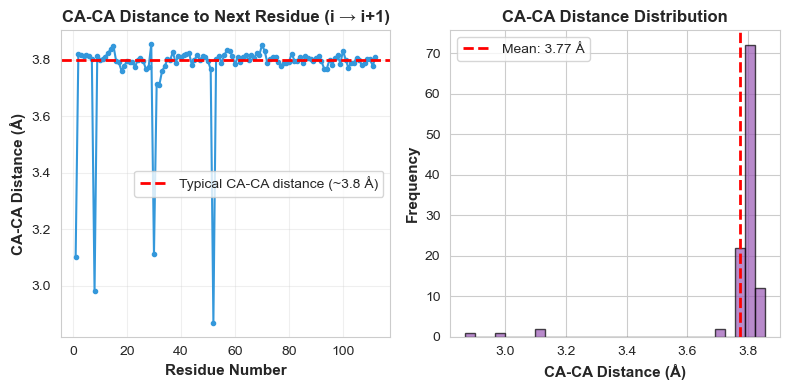


CA-CA Distance Statistics (i → i+1):
  Mean:   3.773 Å
  Median: 3.801 Å
  Std:    0.149 Å
  Min:    2.869 Å
  Max:    3.855 Å


In [20]:
# Local CA distances
df_ca = df_A.dropna(subset=['ca_dist_to_next'])

if len(df_ca) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
    # 1. CA-CA distance i to i+1 (peptide bond)
    axes[0].plot(df_ca['resseq'], df_ca['ca_dist_to_next'], 
                 color='#3498db', linewidth=1.5, marker='o', markersize=3)
    axes[0].axhline(3.8, color='red', linestyle='--', linewidth=2, 
                    label='Typical CA-CA distance (~3.8 Å)')
    axes[0].set_xlabel('Residue Number', fontsize=11, fontweight='bold')
    axes[0].set_ylabel('CA-CA Distance (Å)', fontsize=11, fontweight='bold')
    axes[0].set_title('CA-CA Distance to Next Residue (i → i+1)', fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 2. Distribution
    axes[1].hist(df_ca['ca_dist_to_next'], bins=30, color='#9b59b6',
                 edgecolor='black', alpha=0.7)
    axes[1].axvline(df_ca['ca_dist_to_next'].mean(), color='red', 
                    linestyle='--', linewidth=2, 
                    label=f'Mean: {df_ca["ca_dist_to_next"].mean():.2f} Å')
    axes[1].set_xlabel('CA-CA Distance (Å)', fontsize=11, fontweight='bold')
    axes[1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
    axes[1].set_title('CA-CA Distance Distribution', fontsize=12, fontweight='bold')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    print(f"\nCA-CA Distance Statistics (i → i+1):")
    print(f"  Mean:   {df_ca['ca_dist_to_next'].mean():.3f} Å")
    print(f"  Median: {df_ca['ca_dist_to_next'].median():.3f} Å")
    print(f"  Std:    {df_ca['ca_dist_to_next'].std():.3f} Å")
    print(f"  Min:    {df_ca['ca_dist_to_next'].min():.3f} Å")
    print(f"  Max:    {df_ca['ca_dist_to_next'].max():.3f} Å")
    
    # Identify unusual distances
    unusual = df_ca[df_ca['ca_dist_to_next'] > 4.5]
    if len(unusual) > 0:
        print(f"\n  ⚠️  Unusual CA-CA distances (>4.5 Å): {len(unusual)} found")
        print("     Possible chain breaks or structural irregularities:")
        for _, row in unusual.iterrows():
            print(f"       {row['residue_id']} → next: {row['ca_dist_to_next']:.2f} Å")
else:
    print("No CA distance data available")

## 8. Analyze Multiple Chains

Let's extract features for all chains and compare them.

In [21]:
# Extract features for all chains
features_all = extract_single_chain_features(
    cx=cx,
    chain_ids=["A", "H", "L"],  # All three chains
    compute_sasa=True,
    compute_geometry=True,
    verbose=True
)

# Convert to DataFrame
df_all = features_to_dataframe(features_all)

Starting single chain residue feature extraction...
  Total residues to analyze: 549
  Chains: A, H, L
  [1/5] Initializing basic features...
  [2/5] Computing distances from chain centers...
  [3/5] Computing local CA-CA distances...
  [4/5] Computing backbone and sidechain angles...
  [5/5] Computing solvent accessible surface area...
  Feature extraction complete! Generated features for 549 residues.
  - Alpha helix: 69
  - Beta sheet:  290
  - Loop/other:  161
  - Buried residues:  0
  - Exposed residues: 0


In [22]:
# Compare chains
print("=" * 80)
print("MULTI-CHAIN COMPARISON".center(80))
print("=" * 80)

for chain_id in ["A", "H", "L"]:
    df_chain = df_all[df_all['chain_id'] == chain_id]
    
    print(f"\nChain {chain_id}:")
    print(f"  Total residues:     {len(df_chain)}")
    print(f"  Alpha helix:        {(df_chain['secondary_structure'] == 'alpha_helix').sum()} ({(df_chain['secondary_structure'] == 'alpha_helix').sum()/len(df_chain)*100:.1f}%)")
    print(f"  Beta sheet:         {(df_chain['secondary_structure'] == 'beta_sheet').sum()} ({(df_chain['secondary_structure'] == 'beta_sheet').sum()/len(df_chain)*100:.1f}%)")
    print(f"  Charged residues:   {df_chain['is_charged'].sum()} ({df_chain['is_charged'].sum()/len(df_chain)*100:.1f}%)")
    print(f"  Hydrophobic:        {df_chain['is_hydrophobic'].sum()} ({df_chain['is_hydrophobic'].sum()/len(df_chain)*100:.1f}%)")
    
    if 'avg_bfactor' in df_chain.columns:
        avg_b = df_chain['avg_bfactor'].mean()
        print(f"  Avg B-factor:       {avg_b:.2f}")
    
    if 'sasa' in df_chain.columns:
        buried = df_chain['is_buried'].sum()
        exposed = df_chain['is_exposed'].sum()
        print(f"  Buried residues:    {buried} ({buried/len(df_chain)*100:.1f}%)")
        print(f"  Exposed residues:   {exposed} ({exposed/len(df_chain)*100:.1f}%)")

print("=" * 80)

                             MULTI-CHAIN COMPARISON                             

Chain A:
  Total residues:     113
  Alpha helix:        14 (12.4%)
  Beta sheet:         56 (49.6%)
  Charged residues:   25 (22.1%)
  Hydrophobic:        46 (40.7%)
  Avg B-factor:       46.22
  Buried residues:    0 (0.0%)
  Exposed residues:   0 (0.0%)

Chain H:
  Total residues:     219
  Alpha helix:        30 (13.7%)
  Beta sheet:         116 (53.0%)
  Charged residues:   35 (16.0%)
  Hydrophobic:        79 (36.1%)
  Avg B-factor:       26.91
  Buried residues:    0 (0.0%)
  Exposed residues:   0 (0.0%)

Chain L:
  Total residues:     217
  Alpha helix:        25 (11.5%)
  Beta sheet:         118 (54.4%)
  Charged residues:   45 (20.7%)
  Hydrophobic:        77 (35.5%)
  Avg B-factor:       24.48
  Buried residues:    0 (0.0%)
  Exposed residues:   0 (0.0%)


## 9. Export Features

Export features to various formats.

In [ ]:
# Export Chain A features to CSV
export_features_csv(
    features_A,
    output_path="chain_A_features.csv",
    include_empty_columns=False
)

In [ ]:
# Export all chains to CSV
export_features_csv(
    features_all,
    output_path="all_chains_features.csv",
    include_empty_columns=False
)

In [ ]:
# Export to JSON
export_features_json(
    features_A,
    output_path="chain_A_features.json",
    pretty=True
)

## END